In [1]:
# ruff: noqa: E402

# Compare methods for high-dimensional parameter estimation

In this example we run ensemble based methods
on a sparse Gauss-linear problem.

- Each response is only affected by $3$ parameters.
- This is represented by a tridiagonal matrix $A$ in the forward model $g(x) = Ax$.
- Parameters are endowed with an AR-structure, yielding an exponential covariance function, mimicking field-parameters.
- All parameters and responses are correlated, but only some are conditionally independent.
- The problem is Gauss-Linear
    - We know the exact prior-to-posterior map.
    -  All methods will sample the true posterior when the number of ensemble members (realizations) is large.
- From tuning $p>n$, the dependence of the prior, and the sparsity of the map $g$, it is easy to induce spurious correlations.

The example is taken from the [iterative-ensemble-smoother](https://github.com/equinor/iterative_ensemble_smoother/blob/main/docs/source/Adaptive.py) library.
It is modified to
- Tune the prior parameter dependence structure
- Tune the effect size in the linear map
- Measure deviation between samples

## Import packages

In [8]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

#from iterative_ensemble_smoother import ESMDA
#from iterative_ensemble_smoother.experimental import AdaptiveESMDA

from graphite_maps.enif import EnIF
from graphite_maps.linear_regression import linear_l1_regression, linear_boost_ic_regression
import networkx as nx

## Create problem data

Some settings worth experimenting with:

- Decreasing `prior_std=1` will pull the posterior solution toward zero.
- Increasing `num_ensemble` will increase the quality of the solution.
- Increasing `num_observations / num_parameters`
  will increase the quality of the solution.

In [4]:
rng = np.random.default_rng(42)

# Dimensionality of the problem
num_parameters = 100
num_observations = 50
num_ensemble = 25
prior_std = 1

# Number of iterations to use in ESMDA
alpha = 1

# Effect of forward mdoel
# Smaller means harder to separate from spurious correlations centered at 0
# Larger means easier increased deviation from prior
effect_size = 0.5

# Auto-regressive effects in truth
phi = 0.95

## Create problem data - sparse tridiagonal matrix $A$

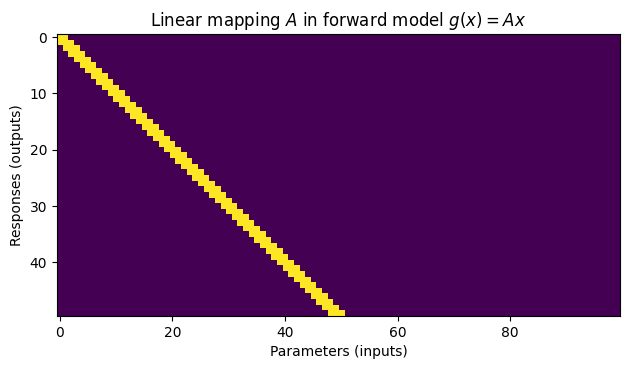

In [5]:
diagonal = effect_size * np.ones(min(num_parameters, num_observations))
#diagonal = effect_size * rng.standard_normal(size=(min(num_parameters, num_observations)))

# Create a tridiagonal matrix (easiest with scipy)
A = sp.sparse.diags(
    [diagonal, diagonal, diagonal],
    offsets=[-1, 0, 1],
    shape=(num_observations, num_parameters),
    dtype=float,
).toarray()

# We add some noise that is insignificant compared to the
# actual local structure in the forward model
#A = A + rng.standard_normal(size=A.shape) * 0.01

plt.title("Linear mapping $A$ in forward model $g(x) = Ax$")
plt.imshow(A)
plt.xlabel("Parameters (inputs)")
plt.ylabel("Responses (outputs)")
plt.tight_layout()
plt.show()

- Below we draw prior realizations $X \sim N(0, \sigma)$.
- The true parameter values used to generate observations are in the range $[-1, 1]$.
- As the number of realizations (ensemble members) goes to infinity,
  the correlation between the prior and the true parameter values converges to zero.
- The correlation is zero for a finite number of realizations too,
  but statistical noise might induce some spurious correlations between
  the prior and the true parameter values.

**In summary the baseline correlation is zero.**
Anything we can do to increase the correlation above zero beats the baseline,
which is using the prior (no update).

The correlation coefficient does not take into account the uncertainty
represeted in the posterior, only the mean posterior value is compared with
the true parameter values.
To compare distributions we could use the
[Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence),
but we do not pursue this here.

In [6]:
def rar1(T, phi, sd_noise=1.0):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, sd_noise**2 / np.sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + sd_noise * np.random.normal(0, 1)
    return x

def get_prior(num_parameters, num_ensemble, prior_std, phi):
    """Sample prior from N(0, prior_std)."""
    return np.array([rar1(T=num_parameters, phi=phi, sd_noise=prior_std) for _ in range(num_ensemble)]).T
    #return rng.normal(size=(num_parameters, num_ensemble)) * prior_std


def g(X):
    """Apply the forward model."""
    return A @ X

# Simulate data

np.random.seed(42)
#U = np.array([rar1(T=p, phi=phi) for _ in range(n)])


# Create observations: obs = g(x) + N(0, 1)

#x_true = np.linspace(-1, 1, num=num_parameters)
x_true = rar1(T=num_parameters, phi=phi, sd_noise=prior_std)
observation_noise = rng.standard_normal(size=num_observations)  # N(0, 1) noise
observations = g(x_true) + observation_noise

# Initial ensemble X ~ N(0, prior_std) and diagonal covariance with ones
X = get_prior(num_parameters, num_ensemble, prior_std, phi)

# Covariance matches the noise added to observations above
covariance = np.ones(num_observations)  # N(0, 1) covariance

## Solve the maximum likelihood problem

We can solve $Ax = b$, where $b$ are the observations,
for the maximum likelihood estimate.

Notice that unlike using a Ridge model,
solving $Ax = b$ directly does not use any prior information.

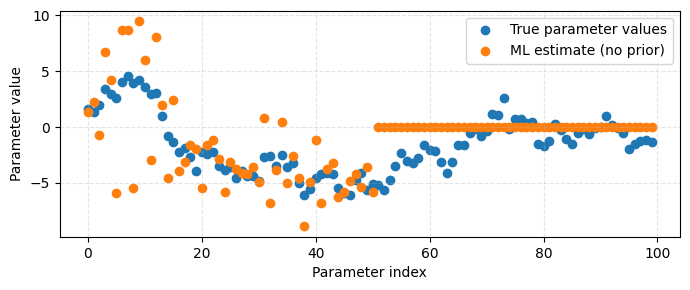

In [7]:
x_ml, *_ = np.linalg.lstsq(A, observations, rcond=None)

plt.figure(figsize=(7, 3))
plt.scatter(np.arange(len(x_true)), x_true, label="True parameter values")
plt.scatter(np.arange(len(x_true)), x_ml, label="ML estimate (no prior)")
plt.xlabel("Parameter index")
plt.ylabel("Parameter value")
plt.grid(True, ls="--", zorder=0, alpha=0.33)
plt.legend()
plt.tight_layout()
plt.show()

## Solve using ESMDA

We create an `ESMDA` instance and solve the Guass-linear problem.

In [191]:
smoother = ESMDA(
    covariance=covariance,
    observations=observations,
    alpha=alpha,
    seed=1,
)

X_i = np.copy(X)
for i, alpha_i in enumerate(smoother.alpha, 1):
    print(
        f"ESMDA iteration {i}/{smoother.num_assimilations()}"
        + f" with inflation factor alpha_i={alpha_i}"
    )
    X_i = smoother.assimilate(X_i, Y=g(X_i))


X_posterior = np.copy(X_i)

ESMDA iteration 1/1 with inflation factor alpha_i=1.0


## Plot and compare solutions

Compare the true parameters with both the ML estimate
from linear regression and the posterior means obtained using `ESMDA`.

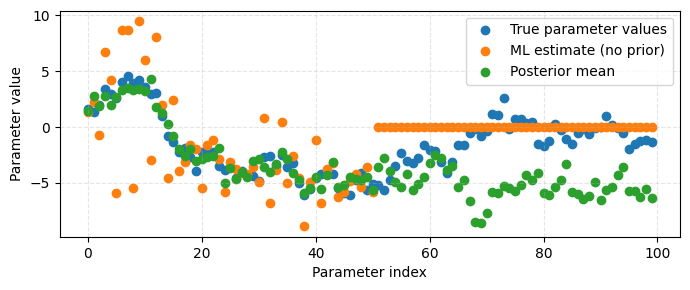

In [192]:
plt.figure(figsize=(7, 3))
plt.scatter(np.arange(len(x_true)), x_true, label="True parameter values")
plt.scatter(np.arange(len(x_true)), x_ml, label="ML estimate (no prior)")
plt.scatter(
    np.arange(len(x_true)), np.mean(X_posterior, axis=1), label="Posterior mean"
)
plt.xlabel("Parameter index")
plt.ylabel("Parameter value")
plt.grid(True, ls="--", zorder=0, alpha=0.33)
plt.legend()
plt.tight_layout()
plt.show()

## Solve using AdaptiveESMDA

We create an `AdaptiveESMDA` instance and solve the Guass-linear problem.

In [193]:
adaptive_smoother = AdaptiveESMDA(
    covariance=covariance,
    observations=observations,
    seed=1,
)

X_i = np.copy(X)

# Loop over alpha defined in ESMDA instance,
# the vector of inflation values alpha is then
# of the same size in AdaptiveESMDA and ESMDA,
# and it's correctly scaled
assert np.isclose(np.sum(1 / smoother.alpha), 1), "Incorrect scaling"
for i, alpha_i in enumerate(smoother.alpha, 1):
    print(
        f"AdaptiveESMDA iteration {i}/{len(smoother.alpha)}"
        + f" with inflation factor alpha_i={alpha_i}"
    )

    # Run forward model
    Y_i = g(X_i)

    # Perturb observations
    D_i = adaptive_smoother.perturb_observations(
        ensemble_size=X_i.shape[1], alpha=alpha_i
    )

    # Assimilate data
    X_i = adaptive_smoother.assimilate(
        X=X_i, Y=Y_i, D=D_i, alpha=alpha_i, verbose=False
    )


X_adaptive_posterior = np.copy(X_i)

AdaptiveESMDA iteration 1/1 with inflation factor alpha_i=1.0


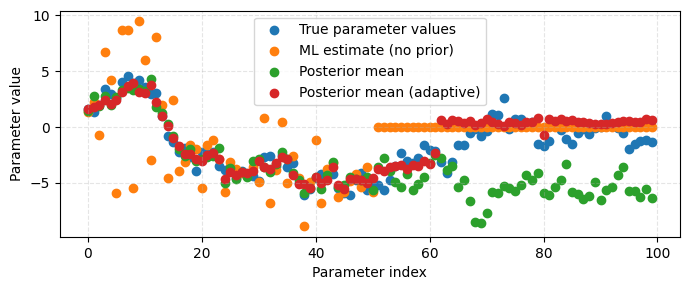

In [194]:
plt.figure(figsize=(7, 3))
plt.scatter(np.arange(len(x_true)), x_true, label="True parameter values")
plt.scatter(np.arange(len(x_true)), x_ml, label="ML estimate (no prior)")
plt.scatter(
    np.arange(len(x_true)), np.mean(X_posterior, axis=1), label="Posterior mean"
)
plt.scatter(
    np.arange(len(x_true)),
    np.mean(X_adaptive_posterior, axis=1),
    label="Posterior mean (adaptive)",
)
plt.xlabel("Parameter index")
plt.ylabel("Parameter value")
plt.grid(True, ls="--", zorder=0, alpha=0.33)
plt.legend()
plt.tight_layout()
plt.show()

## Solve using Non-Structured LASSO


In [9]:
X_prior = np.copy(X)
Y = g(X_prior)
D = Y + rng.standard_normal(size=Y.shape)
#K = linear_l1_regression(U=D.T, Y=X_prior.T)
K = linear_boost_ic_regression(U=D.T, Y=X_prior.T)
X_posterior_lasso = X_prior + K @ (observations - Y.T).T

Learning sparse linear map for each response: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 167.67it/s]


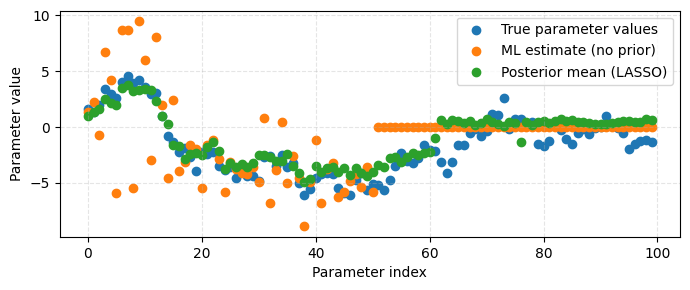

In [10]:
plt.figure(figsize=(7, 3))
plt.scatter(np.arange(len(x_true)), x_true, label="True parameter values")
plt.scatter(np.arange(len(x_true)), x_ml, label="ML estimate (no prior)")
#plt.scatter(
#    np.arange(len(x_true)), np.mean(X_posterior, axis=1), label="Posterior mean"
#)
#plt.scatter(
#    np.arange(len(x_true)),
#    np.mean(X_adaptive_posterior, axis=1),
#    label="Posterior mean (adaptive)",
#)
plt.scatter(
    np.arange(len(x_true)),
    np.mean(X_posterior_lasso, axis=1),
    label="Posterior mean (LASSO)",
)
plt.xlabel("Parameter index")
plt.ylabel("Parameter value")
plt.grid(True, ls="--", zorder=0, alpha=0.33)
plt.legend()
plt.tight_layout()
plt.show()

# Ensemble information filter

In [11]:
# Create graph corresponding prior: independence
G = nx.Graph()
neighbour_distance = 1 if phi != 0 else 0
# vertices
for i in range(num_parameters):
    # edges
    G.add_node(i)
    # vertices
    for j in range(i+1, min(i + neighbour_distance + 1, num_parameters)):
        G.add_edge(i, j)
            
# Be specific about precision of noise
Prec_eps = sp.sparse.diags(
    [np.repeat(1.0, num_observations)], 
    offsets=[0],
    shape=(num_observations, num_observations), 
    format='csc'
)

# Create EnIF object
gtmap = EnIF(Graph_u = G, Prec_eps=Prec_eps)

# Fit precision and sparse mapping
U = np.copy(X).T
Y = g(U.T).T
d = np.copy(observations)

# Fit both precision and sparse linear map H
gtmap.fit(U, Y)

# Transport prior ensemble to posterior ensemble
U_posterior = gtmap.transport(U, d)
X_posterior_enif_graph = U_posterior.T

Learning sparse linear map for each response: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.57it/s]


TypeError: EnIF.transport() missing 1 required positional argument: 'd'

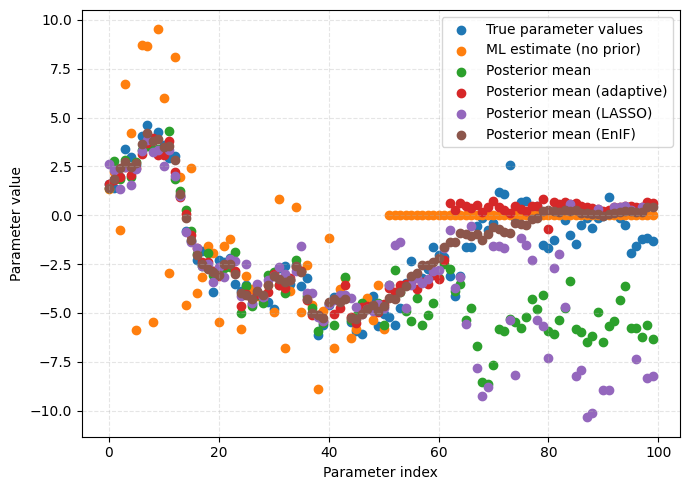

In [198]:
plt.figure(figsize=(7, 5))
plt.scatter(np.arange(len(x_true)), x_true, label="True parameter values")
plt.scatter(np.arange(len(x_true)), x_ml, label="ML estimate (no prior)")
plt.scatter(
    np.arange(len(x_true)), np.mean(X_posterior, axis=1), label="Posterior mean"
)
plt.scatter(
    np.arange(len(x_true)),
    np.mean(X_adaptive_posterior, axis=1),
    label="Posterior mean (adaptive)",
)
plt.scatter(
    np.arange(len(x_true)),
    np.mean(X_posterior_lasso, axis=1),
    label="Posterior mean (LASSO)",
)
plt.scatter(
    np.arange(len(x_true)),
    np.mean(X_posterior_enif_graph, axis=1),
    label="Posterior mean (EnIF)",
)
plt.xlabel("Parameter index")
plt.ylabel("Parameter value")
plt.grid(True, ls="--", zorder=0, alpha=0.33)
plt.legend()
plt.tight_layout()
plt.show()

With EnIF we have the ability to use knowledge of prior sampling as well, not just structure

In [199]:
# Exact prior precision
Prec_u_exact = sp.sparse.diags(
    [np.repeat(-phi, num_parameters-1), 
     np.concatenate(([1.0], np.repeat(1.0+phi**2, num_parameters-2), [1.0])), 
     np.repeat(-phi, num_parameters-1)], 
    offsets=[-1,0,1],
    shape=(num_parameters, num_parameters), 
    format='csc'
)

# But H needs to be learnt
gtmap_known_prec = EnIF(Prec_u = Prec_u_exact, Prec_eps=Prec_eps)

# Fit both precision and sparse linear map H
gtmap_known_prec.fit(U, Y)

# Transport prior ensemble to posterior ensemble
U_posterior2 = gtmap_known_prec.transport(U, d)
X_posterior_enif_prec = U_posterior2.T

Precision u exists. Use `fit_precision` to refit if necessary


Learning sparse linear map for each response: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.86it/s]


# Optimal posterior update

Use knowledge of prior sampling and $g(X)=AX$ to construct exact posterior update

In [200]:
# Exact linear map
H = sp.sparse.csc_matrix(A)

# Create EnIF object
gtmap_exact = EnIF(Prec_u = Prec_u_exact, H=H, Prec_eps=Prec_eps)

# Extract U and d
U = np.copy(X).T
d = np.copy(observations)

# No statistical fitting is needed. We can do an optimal transport
X_posterior_exact = gtmap_exact.transport(U, d).T

In [201]:
def corr_optimal_udpate(X_optimal_posterior, X_model_posterior):
    p, _ = X_optimal_posterior.shape
    corr = 0.0
    for i in range(p):
        corr += sp.stats.pearsonr(X_optimal_posterior[i,:], X_model_posterior[i,:]).statistic
    return corr / p

Note that methods employs different sampling seeds internally, 
thus correlations on samples are **not necessarily 1.0(!).**
In particular, LASSO without structure will learn exactly the sampling noise, and might inherit some bias due to this.

**TODO:** should find a better way to do this

In [202]:
# Anything above 0 is a positive
print(corr_optimal_udpate(X_posterior_exact, X)) # Baseline 1
print(corr_optimal_udpate(X_posterior_exact, X_posterior)) # Baseline 2
print(corr_optimal_udpate(X_posterior_exact, X_adaptive_posterior))
print(corr_optimal_udpate(X_posterior_exact, X_posterior_lasso)) # 
print(corr_optimal_udpate(X_posterior_exact, X_posterior_enif_graph))
print(corr_optimal_udpate(X_posterior_exact, X_posterior_enif_prec))

0.5370401114872301
0.4598799701450573
0.7007256914400978
0.671863240924569
0.7824622456157952
0.7708697648391315


# Some results from tweeking parameters
- When the `effect_size` or `phi` are "large", then an update is important: The prior does not correlate much with the posterior sample.
- Contrary, it is important to _not update_ and retain the prior with small `effect_size` or high independence among parameters.
- **ES-MDA** easily adapts to noise and can perform worse then no update, if an update is not too important.
- **Adaptive-localization** performs well when $K$ is exactly sparse: Requires sparse $H$, $\Sigma_x$ and $\Sigma_y$, and elements in $H$ to be significantly larger than the threshold, to be highly efficient. Seems a significant improvement upon ES-MDA. Note that even if `K` initially is sparse, parameters gets entangled at subsequent iterations of an MDA approach (or just using prior as a posterior later).
- **LASSO-unstructured** performs well under all circumstances, but computationally slow. Outperforms Adaptive-localization generally, but not under conditions where Adaptive-localization is most efficient (sparse $K$ and $H$ elements large). LASSO signifies importance of optimizing parameters -- model selection before or under fitting. This is contrary to Adaptive-localization. The effect increases in importance at high dimensions.
- **EnIF::graph** outperforms all other methods under all conditions and often with a large margin. Computationally fast. Particularly well suited for when $K$ is not sparse, but there exist underlying structure built-in to $\Sigma_x^{-1}$ and $\Sigma_\epsilon^{-1}$. The structure can be either exact or a good parsimoneous model assumption.
- **EnIF::known-precision** the same as **EnIF::graph**, but benefits from improved prior knowledge on precision. Computationally very fast as it only fits LASSO on $h:x\to y$.

# Notes on what can be improved

The following reasons are reasons to not read too much into preliminary results on comparisons:

- Evaluation of methods should be done using unseen test-data.
- Objective of evaluation, at $n->\infty$ is most efficiently (in terms of CR-lower bound) the Gaussian-NLL of data `(x,d)`.
- - Follows from asymptotic efficiency of the ML and its invariance property. $K$ is a function of covariance blocks.
- Methods should be compared on learning from identical samples. Both `EnIF` and `SIES` methods have internal sampling of measurement perturbation.